In [1]:
import tuw_nlp
tuw_nlp.download_alto()
tuw_nlp.download_definitions()

from xpotato.dataset.dataset import Dataset
from xpotato.models.trainer import GraphTrainer
from xpotato.models.utils import to_dot
from xpotato.graph_extractor.extract import FeatureEvaluator
from xpotato.dataset.utils import save_dataframe
from xpotato.dataset.utils import ud_to_graph
from xpotato.dataset.utils import default_pn_to_graph
from xpotato.dataset.utils import amr_pn_to_graph
from xpotato.graph_extractor.rule import RuleSet, Rule

from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import stanza
import os
from graphviz import Source
import pickle
import json
import numpy
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix

stanza.download("en")
stanza.download("de")
stanza.download(lang="en",package=None,processors={"pos":"craft"})


2023-01-26 15:18:49,856 : common (424) - INFO - Downloading default packages for language: en (English)...
2023-01-26 15:18:54,422 : common (140) - INFO - File exists: C:\Users\Ana\stanza_resources\en\default.zip.
2023-01-26 15:19:01,912 : common (465) - INFO - Finished downloading models and saved to C:\Users\Ana\stanza_resources.
2023-01-26 15:19:04,170 : common (424) - INFO - Downloading default packages for language: de (German)...
2023-01-26 15:19:07,519 : common (140) - INFO - File exists: C:\Users\Ana\stanza_resources\de\default.zip.
2023-01-26 15:19:14,972 : common (465) - INFO - Finished downloading models and saved to C:\Users\Ana\stanza_resources.
2023-01-26 15:19:15,084 : common (446) - INFO - Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| pos       | craft   |
| pretrain  | craft   |

2023-01-26 15:19:15,164 : common (140) - INFO - File exists: C:\Users\Ana\stanza_resources\en\pos\craft.pt.
2023-01-26 1

------------------------

## FoodDisease dataset

In [2]:
df = pd.read_csv(Path('../data/milestone3/preprocessed.csv'), sep=';')
df = df[df['source'] == 'FoodDisease']
df['prp_sent'] = df['prp_sent'].apply(lambda x: x.replace('term1', 'influence'). replace('term2', 'condition'))
df['sdp_joined'] = df['sdp_joined'].apply(lambda x: x.replace('term1', 'influence'). replace('term2', 'condition'))
# Only food disease because CrowdTruth is too bad quality
labels = df[['is_cause', 'is_treat']][df['source'] == 'FoodDisease']
print(len(labels))
print(labels.sum(axis=0))
df.head()

588
is_cause    132
is_treat    313
dtype: int64


,term1,term2,sentence,is_cause,is_treat,source,prp_sent,sdp,sdp_joined
0,bombax ceiba l. (bombacaceae) fruits,urinary stones,"interestingly, many indian tribes use bombax c...",0,1,FoodDisease,"interestingly, many indian tribes use influenc...","['term1', 'use', 'as', 'medicine', 'for', 'tre...",influence use as medicine for treatment of con...
1,ultra-processed food,obesity,ultra-processed food consumption has been asso...,1,0,FoodDisease,influence consumption has been associated with...,"['term1', 'consumption', 'associate', 'with', ...",influence consumption associate with outcome a...
2,salt,osteoporosis,salt has notoriously been blamed for causing a...,1,0,FoodDisease,influence has notoriously been blamed for caus...,"['term1', 'blame', 'for', 'term2']",influence blame for condition
3,broiler chicken,footpad dermatitis,in broiler chicken flocks when animal-based me...,0,0,FoodDisease,in influence flocks when animal-based measures...,"['term1', 'flock', 'in', 'identify', 'burn', '...","influence flock in identify burn , condition"
4,sfp,diabetes,"in short, this study demonstrated that sfp cou...",0,1,FoodDisease,"in short, this study demonstrated that influen...","['term1', 'develop', 'as', 'food', 'or', 'prev...",influence develop as food or prevention of con...


In [3]:
def make_sentences(column="is_cause", df=df):
    sentences = []
    for i, row in df.iterrows():
        if row[column]:
            if column == "is_cause":
                relation = 'cause'
            else:
                relation="treat"
        else:
            relation = 'not'
        sentence = row['prp_sent'].encode('ascii', errors='ignore').decode('utf-8')
        sentences.append((sentence, relation))
    return sentences

## Full sentence

In [4]:
sentences_cause = make_sentences("is_cause", df)
sentences_treat = make_sentences("is_treat", df)

In [5]:
sentences_cause[1:5]

[('influence consumption has been associated with several health outcomes such as condition, hypertension, cardiovascular disease and cancer.',
  'cause'),
 ('influence has notoriously been blamed for causing an increase in the urinary excretion of calcium, and thus is a considered a risk factor for condition.',
  'cause'),
 ('in influence flocks when animal-based measures related to condition, hock burns, body lesions and arthritis are identified under commercial conditions (high density).',
  'not'),
 ('in short, this study demonstrated that influence could be developed as functional foods or pharmaceutical supplements for the prevention or mitigation of condition and its complications.',
  'not')]

In [6]:
dataset_cause = Dataset(sentences_cause, label_vocab={"not":0, "cause": 1}, lang="en")
dataset_treat = Dataset(sentences_treat, label_vocab={"not":0, "treat": 1}, lang="en")

In [7]:
# make graphs, slow on big dataet
#dataset_treat.set_graphs(dataset_treat.parse_graphs(graph_format="fourlang"))

In [8]:
# save dataframe
#df_treat = dataset_treat.to_dataframe()
#save_dataframe(df_treat, '../data/milestone3/df_treat_graphs_subset.tsv')

In [9]:
# make graphs, slow on big dataset
#dataset_cause.set_graphs(dataset_cause.parse_graphs(graph_format="fourlang"))

In [10]:
# save dataframe
#df_cause = dataset_cause.to_dataframe()
#save_dataframe(df_cause, '../data/milestone3/df_cause_graphs_subset.tsv')

In [11]:
# load dataframes
df_cause = pd.read_csv(Path('../data/milestone3/df_cause_graphs_subset.tsv'), sep='\t')
df_cause['graph'] = df_cause['graph'].apply(lambda x: amr_pn_to_graph(x)[0])

df_treat = pd.read_csv(Path('../data/milestone3/df_treat_graphs_subset.tsv'), sep='\t')
df_treat['graph'] = df_treat['graph'].apply(lambda x: amr_pn_to_graph(x)[0])

-----------------------------

POTATO framework uses both machine learning and rule-based systems in the way that ML is used to learn the rules, generate them. After the framework suggests the rules, based on feature importance, the user then decides whether to keep/adjust/discard the rule. The idea is to use subgraphs as features for training simple classifiers. Subgraphs are generated only up to a certain edge number.

### Treat relation

example graph for a sentence:

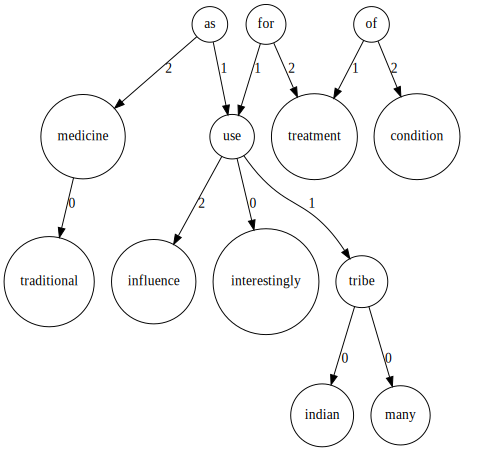

In [12]:
Source(to_dot(df_treat.iloc[0].graph))

#### Learning rules

First we will allow feature rules to contain no edges, meaning they can be just terms. We allow this by leaving the default value for min_edges=0 in trainer.prepare_and_train().

In [13]:
treat_train, treat_val = train_test_split(df_treat, test_size=0.1, random_state=1)

trainer = GraphTrainer(treat_train)

treat_features = trainer.prepare_and_train()


Initializing trainer object...
Featurizing graphs by generating subgraphs up to 2...


529it [00:06, 84.87it/s] 


Getting feature graphs...
Selecting the best features...
Generating training data...
Training...
Getting features...


In [14]:
treat_features["treat"][:10]

[(['(u_114 / reduce)'], [], 'treat'),
 (['(u_227 / decrease)'], [], 'treat'),
 (['(u_76 / against)'], [], 'treat'),
 (['(u_108 / prevent)'], [], 'treat'),
 (['(u_57 / improve)'], [], 'treat'),
 (['(u_117 / component)'], [], 'treat'),
 (['(u_138 / compound)'], [], 'treat'),
 (['(u_486 / low)'], [], 'treat'),
 (['(u_421 / treat)'], [], 'treat'),
 (['(u_76 / against  :2 (u_21 / condition))'], [], 'treat')]

As expected, the best rules/features were just terms.

In [15]:
treat_evals, treat_acc = trainer.evaluator.evaluate_feature("treat", treat_features["treat"][:10], treat_train)

In [16]:
treat_evals[["Feature", "Precision", "Recall", "Fscore"]]


,Feature,Precision,Recall,Fscore
0,[(u_114 / reduce)],0.866667,0.185714,0.305882
1,[(u_227 / decrease)],0.833333,0.035714,0.068493
2,[(u_76 / against)],0.939394,0.110714,0.198083
3,[(u_108 / prevent)],0.931034,0.096429,0.174757
4,[(u_57 / improve)],0.950000,0.067857,0.126667
5,[(u_117 / component)],0.950000,0.067857,0.126667
6,[(u_138 / compound)],0.913043,0.075000,0.138614
7,[(u_486 / low)],0.733333,0.078571,0.141935
8,[(u_421 / treat)],0.904762,0.067857,0.126246
9,[(u_76 / against :2 (u_21 / condition))],1.000000,0.064286,0.120805


Let's see how many sentences match the top rules:

In [72]:
evaluator = FeatureEvaluator()

def subset_rule(df, rule_to_match, label="treat"):
    df_tmp = evaluator.match_features(df, rule_to_match)
    rows = []
    for i,row in df_tmp.iterrows():
        if row['Predicted label'] == label:
            row['graph'] = df.iloc[i].graph
            rows.append(row)
    df_tmp = pd.DataFrame(rows, columns=['Sentence', 'Predicted label', 'Matched rule', 'graph']).reset_index(drop=True)
    return df_tmp


In [18]:
def subset_rule_cause(df, rule_to_match):
    df_tmp = evaluator.match_features(df, rule_to_match)
    rows = []
    for i,row in df_tmp.iterrows():
        if row['Predicted label'] == 'cause':
            row['graph'] = df.iloc[i].graph
            rows.append(row)
    df_tmp = pd.DataFrame(rows, columns=['Sentence', 'Predicted label', 'Matched rule', 'graph']).reset_index(drop=True)
    return df_tmp

Reduce

In [19]:
# The syntax of the rules is List[List[rules that we want to match], List[rules that shouldn't be in the matched graphs], Label of the rule]
rule_to_match = [[["(u_76 / against :2 (u_21 / condition))"], [], "treat"]]
df_reduce = subset_rule(treat_train, rule_to_match)

529it [00:00, 5084.90it/s]


In [20]:
print("Reduce in "+str(len(df_reduce))+" sentences.")

Reduce in 18 sentences.


In [21]:
print("Example sentences:")
for i in range (10):
    print(df_reduce.iloc[i].Sentence+ "\n")

Example sentences:
natural products like ginger, turmeric, garlic, onion, cinnamon, influence, neem, basil, and black pepper have been scientifically proven to have therapeutic benefits against acute condition including pulmonary fibrosis, diffuse alveolar damage, pneumonia, and acute respiratory distress syndrome, as well as associated septic shock, lung and kidney injury, all of which are symptoms associated with covid-19 infection.

diallyl disulfide (dads), a sulfur compound derived from influence, has been shown to have protective effects against condition in several studies performed in rodent models.

influence is a promising functional food against condition, owing to a variety of bioactive compounds.

numerous authors have provided evidence regarding the beneficial effects of influence and their derivatives against condition (ad).

cell culture studies suggest that phytoestrogens, abundant in soy products such as tempe and influence, could protect against condition.

influence

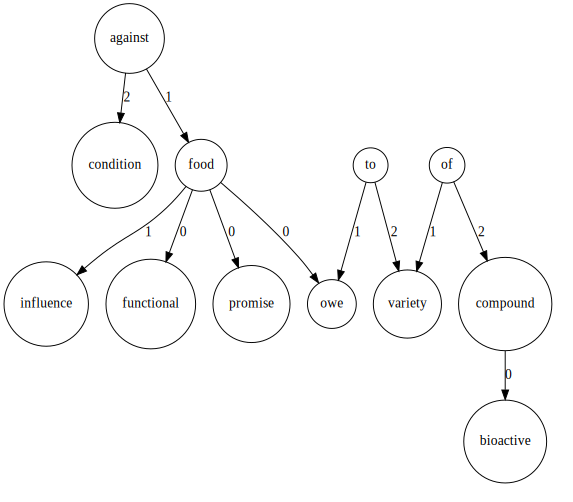

In [22]:
Source(to_dot(df_reduce.iloc[2].graph))

Prevent

In [23]:
rule_to_match = [[["(u_1 / prevent)"], [], "treat"]]
df_prevent = subset_rule(treat_train, rule_to_match)

529it [00:00, 4477.26it/s]


In [24]:
print("Prevent in "+str(len(df_prevent))+" sentences.")

Prevent in 29 sentences.


In [25]:
print("Example sentences:")
for i in range (3):
    print(df_prevent.iloc[i].Sentence+ "\n")

Example sentences:
the judicious use of milk and influence could prevent a high proportion of condition.

xuezhikang (xzk), an extract derived from influence, is commonly employed as a traditional chinese medicine for treating condition, improving endothelial function, decreasing blood lipids and preventing other cardiovascular events both within china and globally.

therefore, novel therapeutic strategies have long been investigated, where curcumin (influence) has shown some properties that can prevent the deleterious processes involved in condition.



Improve

In [26]:
rule_to_match = [[["(u_1 / improve)"], [], "treat"]]
df_improve = subset_rule(treat_train, rule_to_match)

529it [00:00, 3854.97it/s]


In [27]:
print("Improve in "+str(len(df_improve))+ " sentences.")

Improve in 20 sentences.


In [28]:
print("Example sentences:")
for i in range (3):
    print(df_improve.iloc[i].Sentence+ "\n")

Example sentences:
influence is a traditional staple crop from pacific islands with the potential to improve worldwide food security and mitigate condition.

previous evidence suggested that influence (evoo) is linked to attenuating amyloid- (a) pathology and improving cognitive function in condition (ad) mouse models.

thus, the inclusion of food sources of dietary antioxidants, such as different kinds of influence, may improve biomarkers related to oxidative stress, contributing to a possible reduction in condition progression.



Against

In [29]:
rule_to_match = [[["(u_1 / against)"], [], "treat"]]
df_against = subset_rule(treat_train, rule_to_match)


529it [00:00, 4408.36it/s]


In [30]:
print("Against in "+str(len(df_against))+ " sentences.")

Against in 33 sentences.


In [31]:
print("Example sentences:")
for i in range (3):
    print(df_against.iloc[i].Sentence+ "\n")

Example sentences:
natural products like ginger, turmeric, garlic, onion, cinnamon, influence, neem, basil, and black pepper have been scientifically proven to have therapeutic benefits against acute condition including pulmonary fibrosis, diffuse alveolar damage, pneumonia, and acute respiratory distress syndrome, as well as associated septic shock, lung and kidney injury, all of which are symptoms associated with covid-19 infection.

influence vegetables have been shown to have beneficial effects against several diseases, including condition.

diallyl disulfide (dads), a sulfur compound derived from influence, has been shown to have protective effects against condition in several studies performed in rodent models.



Let's test it, we will define a ruleset from the top 5 rules/features:

In [32]:
# Create a ruleset from the features
feature1 = ['(u_0 / reduce)'], [], 'treat', [{'token': 0}]
feature2 = ['(u_0 / decrease)'], [], 'treat', [{'token': 0}]
feature3 = ['(u_0 / against)'], [], 'treat', [{'token': 0}]
feature4 = ['(u_0 / prevent)'], [], 'treat', [{'token': 0}]
feature5 = ['(u_0 / improve)'], [], 'treat', [{'token': 0}]

rule_set = RuleSet([Rule(feature1, openie=True), Rule(feature2, openie=True), Rule(feature3, openie=True), Rule(feature4, openie=True), Rule(feature5, openie=True)])# 

In [33]:
duos = []
for graph in treat_val.graph:
    duo= list(evaluator.annotate(graph, rule_set.to_list()))
    if len(duo) != 0:
        duos.append([duo[0]['relation'], duo[0]['token']])
    else:
        duos.append(["not", "-"])

d = {
            "Sentence": treat_val.text.tolist(),
            "True label": treat_val.label.tolist(),
            "Predicted label": [duo[0] for duo in duos],
            "Matched term": [duo[1] for duo in duos],
}
df = pd.DataFrame(data=d)

In [34]:
df

,Sentence,True label,Predicted label,Matched term
0,"catechins, phytochemicals contained mainly in ...",treat,treat,against
1,influence products are believed to contain man...,treat,treat,against
2,since influence has been related to the develo...,treat,not,-
3,"in adult caucasian women, daily intake of 200-...",treat,not,-
4,"regular consumption of influence (e.g., kimchi...",treat,not,-
5,extensive research over the last 10 years has ...,treat,treat,prevent
6,"interestingly, many indian tribes use influenc...",treat,not,-
7,influence is a driver of general and condition...,not,not,-
8,proteins and peptides in influence and bones a...,treat,not,-
9,"our findings strongly suggest that some foods,...",treat,treat,reduce


In [35]:
def evalute_ruleset(df, label='treat'):
    tp = len(df[df['True label']==label][df['Predicted label']==label])
    tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
    fp = len(df[df['True label']=='not'][df['Predicted label']==label])
    fn = len(df[df['True label']==label][df['Predicted label']=='not'])
    acc = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    return acc, precision, recall, f1

acc, precision, recall, f1 = evalute_ruleset(df)

C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']==label][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']==label][df['Predicted label']=='not'])


In [36]:
print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

Accuracy: 0.6779661016949152
Precision: 1.0
Recall: 0.42424242424242425
F1: 0.5957446808510638


With 5 rules, in this case terms, we are able to determine the relation with 67.8% accuracy.

Let's now try with all the rules extracted:

In [37]:
treat_features['treat']

[(['(u_114 / reduce)'], [], 'treat'),
 (['(u_227 / decrease)'], [], 'treat'),
 (['(u_76 / against)'], [], 'treat'),
 (['(u_108 / prevent)'], [], 'treat'),
 (['(u_57 / improve)'], [], 'treat'),
 (['(u_117 / component)'], [], 'treat'),
 (['(u_138 / compound)'], [], 'treat'),
 (['(u_486 / low)'], [], 'treat'),
 (['(u_421 / treat)'], [], 'treat'),
 (['(u_76 / against  :2 (u_21 / condition))'], [], 'treat'),
 (['(u_135 / antiHYPHENcondition)'], [], 'treat'),
 (['(u_194 / ad)'], [], 'treat'),
 (['(u_54 / traditional)'], [], 'treat'),
 (['(u_156 / vegetable)'], [], 'treat'),
 (['(u_288 / protective)'], [], 'treat'),
 (['(u_359 / epidemiological)'], [], 'treat'),
 (['(u_74 / benefit)'], [], 'treat'),
 (['(u_4 / with  :2 (u_8 / COORD)  :1 (u_89 / associate))'], [], 'treat'),
 (['(u_12 / of  :1 (u_681 / prevention))'], [], 'treat'),
 (['(u_134 / antiHYPHENinflammatory)'], [], 'treat'),
 (['(u_12 / of  :1 (u_210 / treatment))'], [], 'treat'),
 (['(u_148 / dietary)'], [], 'treat'),
 (['(u_189 / fu

In [38]:
len(treat_features['treat'])

124

In [39]:
rules_treat = []
for i in range (len(treat_features['treat'])):
    splits = treat_features['treat'][i][0][0].split()
    feature = '(u_0'
    for i in range(1, len(splits)):
        feature += ' ' + splits[i]
    feature = ([feature], treat_features["treat"][i][1], treat_features["treat"][i][2], [{'token': 0}])
    rules_treat.append(Rule(feature, openie=True))

We will add a rule at a time and evalute the dataset:

In [40]:
def get_validation_df(ruleset, df):
    duos = []
    for graph in df.graph:
        duo= list(evaluator.annotate(graph, ruleset.to_list()))
        if len(duo) != 0:
            duos.append([duo[0]['relation'], duo[0]['token']])
        else:
            duos.append(["not", "-"])

    d = {
                "Sentence": df.text.tolist(),
                "True label": df.label.tolist(),
                "Predicted label": [duo[0] for duo in duos],
                "Matched term": [duo[1] for duo in duos],
    }
    return pd.DataFrame(data=d)

In [41]:
evaluations_treat_0 = []
for i in tqdm(range(1, len(rules_treat))):
    rule_subset = rules_treat[0:i]
    ruleset = RuleSet(rule_subset)
    df = get_validation_df(ruleset, treat_train)
    acc, precision, recall, f1 = evalute_ruleset(df)
    evaluations_treat_0.append([acc, precision, recall, f1])


  0%|          | 0/123 [00:00<?, ?it/s]C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']==label][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']==label][df['Predicted label']=='not'])
100%|██████████| 123/123 [25:14<00:00, 12.31s/it]


In [42]:
df_eval_treat_0 = pd.DataFrame(evaluations_treat_0, columns=['Accuracy', 'Precision', 'Recall', 'F1'])

In [43]:
df_eval_treat_0

,Accuracy,Precision,Recall,F1
0,0.553875,0.866667,0.185714,0.305882
1,0.567108,0.859155,0.217857,0.347578
2,0.621928,0.884615,0.328571,0.479167
3,0.669187,0.900763,0.421429,0.574209
4,0.689981,0.902778,0.464286,0.613208
...,...,...,...,...
118,0.531191,0.530418,0.996429,0.692308
119,0.531191,0.530418,0.996429,0.692308
120,0.531191,0.530418,0.996429,0.692308
121,0.531191,0.530418,0.996429,0.692308


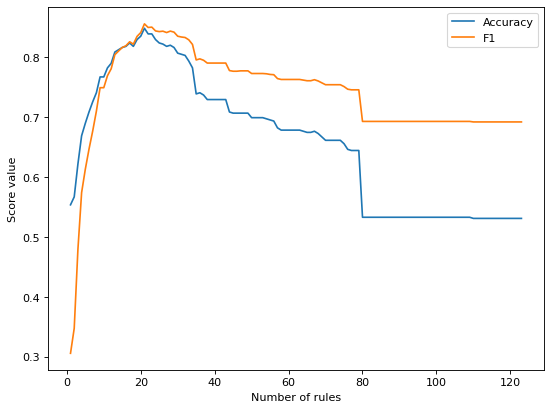

In [44]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(range(1, len(rules_treat), 1), df_eval_treat_0["Accuracy"])
plt.plot(range(1, len(rules_treat), 1), df_eval_treat_0["F1"])
plt.xlabel("Number of rules")
plt.ylabel("Score value")
plt.legend(['Accuracy', 'F1'])

We get the best results when using 20 rules.

Behavior on test dataset

In [45]:
rule_subset = rules_treat[0:20]
ruleset = RuleSet(rule_subset)
df = get_validation_df(ruleset, treat_val)
acc, precision, recall, f1 = evalute_ruleset(df)

C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']==label][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']==label][df['Predicted label']=='not'])


In [46]:
print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

Accuracy: 0.7457627118644068
Precision: 0.8461538461538461
Recall: 0.6666666666666666
F1: 0.7457627118644068


In [48]:
def evaluate_class(y, pred, class_name, title):
    
    conf_mat = confusion_matrix(y, pred)
    y_tick_labels = [f'{class_name}=False', f'{class_name}=True']
    x_tick_labels = ['(pred) ' + l for l in y_tick_labels]
    sns.set(rc={'figure.figsize':(7, 6)})
    sns.heatmap(conf_mat, xticklabels=x_tick_labels, yticklabels=y_tick_labels, annot=True, fmt='.3g'
        ).set(title=title)

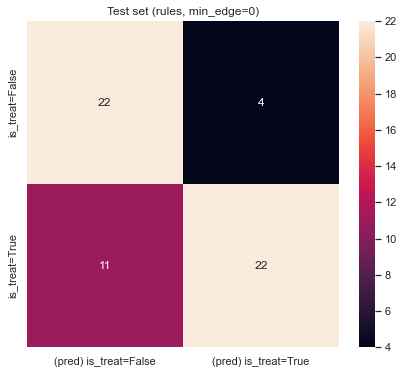

In [49]:
evaluate_class(df['True label'], df['Predicted label'], 'is_treat', 'Test set (rules, min_edge=0)')

Let's expand the rules now by adding the restriction of min_edge = 1, meaning our rules will have to have more than a term.

In [50]:
treat_train, treat_val = train_test_split(df_treat, test_size=0.1, random_state=1)

trainer = GraphTrainer(treat_train)

treat_features = trainer.prepare_and_train(min_edge = 1)


Initializing trainer object...
Featurizing graphs by generating subgraphs up to 2...


529it [00:04, 112.40it/s]


Getting feature graphs...
Selecting the best features...
Generating training data...
Training...
Getting features...


In [51]:
treat_features["treat"][:10]

[(['(u_76 / against  :2 (u_21 / condition))'], [], 'treat'),
 (['(u_4 / with  :2 (u_8 / COORD)  :1 (u_89 / associate))'], [], 'treat'),
 (['(u_12 / of  :1 (u_681 / prevention))'], [], 'treat'),
 (['(u_12 / of  :1 (u_210 / treatment))'], [], 'treat'),
 (['(u_12 / of  :1 (u_8 / COORD))'], [], 'treat'),
 (['(u_12 / of  :2 (u_21 / condition))'], [], 'treat'),
 (['(u_65 / for  :2 (u_210 / treatment))'], [], 'treat'),
 (['(u_8 / COORD  :0 (u_57 / improve))'], [], 'treat'),
 (['(u_12 / of  :1 (u_117 / component))'], [], 'treat'),
 (['(u_8 / COORD  :0 (u_21 / condition)  :0 (u_154 / diabete))'], [], 'treat')]

In [52]:
treat_evals, treat_acc = trainer.evaluator.evaluate_feature("treat", treat_features["treat"][:10], treat_train)

In [53]:
treat_evals[["Feature", "Precision", "Recall", "Fscore"]]

,Feature,Precision,Recall,Fscore
0,[(u_76 / against :2 (u_21 / condition))],1.000000,0.064286,0.120805
1,[(u_4 / with :2 (u_8 / COORD) :1 (u_89 / ass...,0.692308,0.032143,0.061433
2,[(u_12 / of :1 (u_681 / prevention))],0.916667,0.039286,0.075342
3,[(u_12 / of :1 (u_210 / treatment))],1.000000,0.057143,0.108108
4,[(u_12 / of :1 (u_8 / COORD))],0.736842,0.050000,0.093645
5,[(u_12 / of :2 (u_21 / condition))],0.580357,0.232143,0.331633
6,[(u_65 / for :2 (u_210 / treatment))],1.000000,0.050000,0.095238
7,[(u_8 / COORD :0 (u_57 / improve))],1.000000,0.039286,0.075601
8,[(u_12 / of :1 (u_117 / component))],0.916667,0.039286,0.075342
9,[(u_8 / COORD :0 (u_21 / condition) :0 (u_15...,0.769231,0.035714,0.068259


In [54]:
rules_treat_1 = []
for i in range (len(treat_features['treat'])):
    splits = treat_features['treat'][i][0][0].split()
    feature = '(u_0'
    for i in range(1, len(splits)):
        feature += ' ' + splits[i]
    feature = ([feature], treat_features["treat"][i][1], treat_features["treat"][i][2], [{'token': 0}])
    rules_treat_1.append(Rule(feature, openie=True))

Creating a ruleset:

In [55]:
evaluations_treat_1 = []
for i in tqdm(range(1, len(rules_treat_1))):
    rule_subset = rules_treat_1[0:i]
    ruleset = RuleSet(rule_subset)
    df = get_validation_df(ruleset, treat_train)
    acc, precision, recall, f1 = evalute_ruleset(df)
    evaluations_treat_1.append([acc, precision, recall, f1])

  0%|          | 0/51 [00:00<?, ?it/s]C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']==label][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']==label][df['Predicted label']=='not'])
100%|██████████| 51/51 [04:27<00:00,  5.25s/it]


In [56]:
df_eval = pd.DataFrame(evaluations_treat_1, columns=['Accuracy', 'Precision', 'Recall', 'F1'])

In [57]:
df_eval

,Accuracy,Precision,Recall,F1
0,0.504726,1.000000,0.064286,0.120805
1,0.512287,0.866667,0.092857,0.167742
2,0.531191,0.880952,0.132143,0.229814
3,0.559546,0.912281,0.185714,0.308605
4,0.567108,0.859155,0.217857,0.347578
5,0.576560,0.672840,0.389286,0.493213
6,0.578450,0.674847,0.392857,0.496614
7,0.595463,0.691860,0.425000,0.526549
8,0.606805,0.700000,0.450000,0.547826
9,0.614367,0.700000,0.475000,0.565957


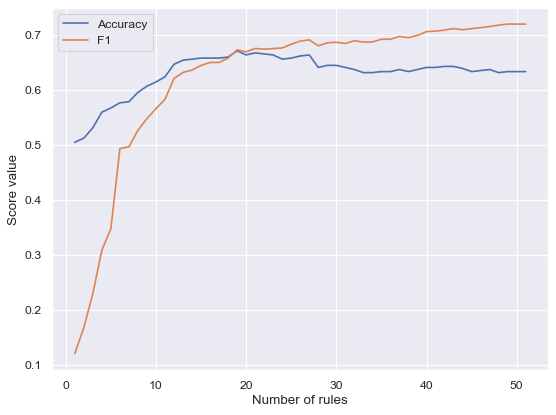

In [58]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(range(1, len(rules_treat_1), 1), df_eval["Accuracy"])
plt.plot(range(1, len(rules_treat_1), 1), df_eval["F1"])
plt.xlabel("Number of rules")
plt.ylabel("Score value")
plt.legend(['Accuracy', 'F1'])

We get the best results when using the first 27 rules.

In [59]:
rule_subset = rules_treat_1[0:27]
ruleset = RuleSet(rule_subset)
df = get_validation_df(ruleset, treat_val)
acc, precision, recall, f1 = evalute_ruleset(df)

C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']==label][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']==label][df['Predicted label']=='not'])


In [60]:
print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

Accuracy: 0.5932203389830508
Precision: 0.6153846153846154
Recall: 0.7272727272727273
F1: 0.6666666666666667


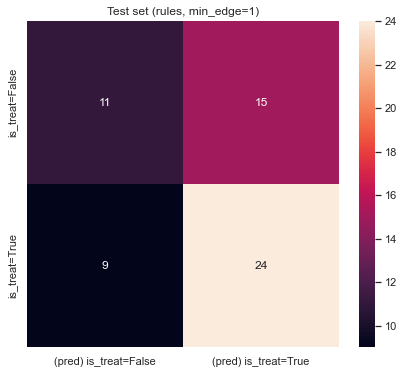

In [61]:
evaluate_class(df['True label'], df['Predicted label'], 'is_treat', 'Test set (rules, min_edge=1)')

As expected, by making the rules more specific the results have dropped a bit with accuracy = 59.32%.

### Cause relation

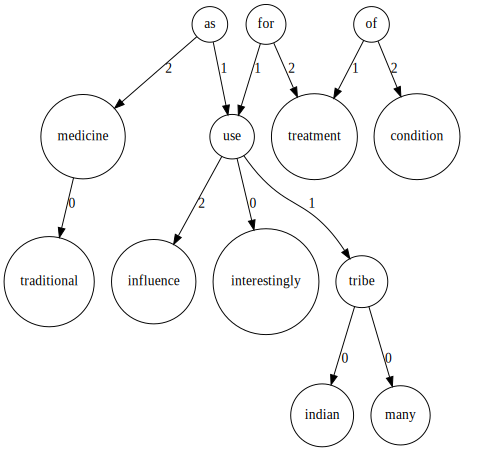

In [62]:
Source(to_dot(df_cause.iloc[0].graph))


### Learning rules


In [63]:
cause_train, cause_val = train_test_split(df_cause, test_size=0.1, random_state=1)

trainer = GraphTrainer(cause_train)

cause_features = trainer.prepare_and_train()


Initializing trainer object...
Featurizing graphs by generating subgraphs up to 2...


529it [00:05, 105.22it/s]


Getting feature graphs...
Selecting the best features...
Generating training data...
Training...
Getting features...


In [64]:
cause_features["cause"][:10]


[(['(u_740 / increase)'], [], 'cause'),
 (['(u_19 / patient)'], [], 'cause'),
 (['(u_66 / symptom)'], [], 'cause'),
 (['(u_363 / protein)'], [], 'cause'),
 (['(u_161 / important)'], [], 'cause'),
 (['(u_110 / high)'], [], 'cause'),
 (['(u_8 / COORD  :0 (u_106 / product))'], [], 'cause'),
 (['(u_460 / among)'], [], 'cause'),
 (['(u_167 / population)'], [], 'cause'),
 (['(u_168 / child)'], [], 'cause')]

In [65]:
cause_evals, cause_acc = trainer.evaluator.evaluate_feature("cause", cause_features["cause"][:10], cause_train)


In [66]:
cause_evals[["Feature", "Precision", "Recall", "Fscore"]]


,Feature,Precision,Recall,Fscore
0,[(u_740 / increase)],0.666667,0.169492,0.270270
1,[(u_19 / patient)],0.428571,0.076271,0.129496
2,[(u_66 / symptom)],0.500000,0.050847,0.092308
3,[(u_363 / protein)],0.437500,0.059322,0.104478
4,[(u_161 / important)],0.400000,0.050847,0.090226
5,[(u_110 / high)],0.407407,0.186441,0.255814
6,[(u_8 / COORD :0 (u_106 / product))],0.461538,0.050847,0.091603
7,[(u_460 / among)],0.600000,0.076271,0.135338
8,[(u_167 / population)],0.500000,0.050847,0.092308
9,[(u_168 / child)],0.538462,0.059322,0.106870


Let's again see how many sentences match the top rules:

Increase

In [73]:
rule_to_match = [[["(u_0 / increase)"], [], "cause"]]
df_increase = subset_rule(cause_train, rule_to_match, label="cause")

529it [00:00, 3918.53it/s]


In [74]:
print("Increase in "+str(len(df_increase))+" sentences")

Increase in 30 sentences


In [75]:
for i in range (3):
    print(df_increase.iloc[i].Sentence+ "\n")

polyphenols from coffee, influence, whortleberry, olive oil, propolis, chocolate, red wine, grape seed, and cocoa have been reported to show anti-condition effects in t2d patients through increasing glucose metabolism, improving vascular function as well as reducing insulin resistance and hba1c level.

in older people in indonesia, hawai'i and china, influence, which can contain high levels of phytoestrogens, was found to increase condition risk.

a relationship between maternal ingestion of influence during early pregnancy and increased risk for condition (ntds) has recently been proposed in human populations around the world where corn is a dietary staple.



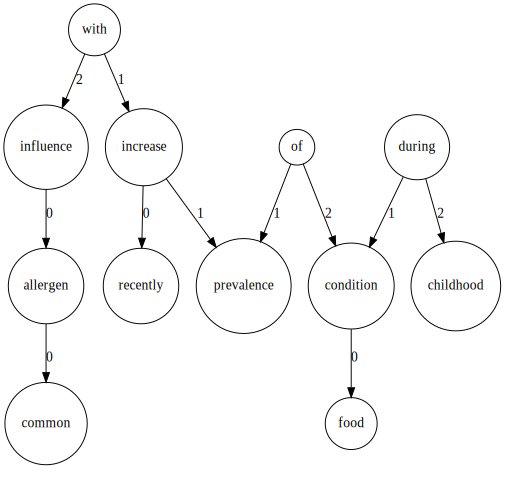

In [76]:
Source(to_dot(df_increase.iloc[8].graph))


Patient

In [80]:
rule_to_match = [[["(u_1 / patient)"], [], "cause"]]
df_patient = subset_rule(cause_train, rule_to_match, label="cause")


529it [00:00, 3595.20it/s]


In [81]:
print("Patient in "+str(len(df_patient))+" sentences")

Patient in 21 sentences


In [82]:
for i in range (3):
    print(df_patient.iloc[i].Sentence+ "\n")

the causes of condition with collagen diseases have been reported to be functional gastrointestinal disorders with collagen diseases like amyloidosis, gastrointestinal infections in immunocompromised patients, and side effects of medication, such as influence or nsaids and mtx.

twenty-three positive bronchial or nasal challenges were performed on 16 patients (six farmers, six bakery workers, and four food industry workers) and condition or rhinitis was diagnosed as caused by cereal flour or grain, cow epithelium, storage mites, influence, or soy dust.

new evidence shows that a influence may be beneficial for some patients with condition, such as those symptoms commonly found in patients with ibs.



Protein

In [86]:
rule_to_match = [[["(u_1 / protein)"], [], "cause"]]
df_protein = subset_rule(cause_train, rule_to_match, label="cause")

529it [00:00, 3419.20it/s]


In [87]:
print("Protein in "+str(len(df_protein))+" sentences")

Protein in 16 sentences


In [88]:
for i in range (3):
    print(df_protein.iloc[i].Sentence+ "\n")

dietary excesses in animal protein and/or influence have been implicated as risk factors in condition.

our previous study suggests that influence root extract can reverse condition and prevent alzheimer's disease (ad)-like symptoms induced by the amyloid- protein (a) in a rat model.

influence is commonly used in algeria for treatment of condition and osteoporosis, it ranks first in terms of vegetal proteins.



Symptom

In [92]:
# The syntax of the rules is List[List[rules that we want to match], List[rules that shouldn't be in the matched graphs], Label of the rule]
rule_to_match = [[["(u_1 / symptom)"], [], "cause"]]
df_symptom = subset_rule(cause_train, rule_to_match, label="cause")

529it [00:00, 3646.14it/s]


In [93]:
print("Symptom in "+ str(len(df_symptom))+" sentences")

Symptom in 12 sentences


In [94]:
for i in range (3):
    print(df_symptom.iloc[i].Sentence+ "\n")

new evidence shows that a influence may be beneficial for some patients with condition, such as those symptoms commonly found in patients with ibs.

natural products like ginger, turmeric, garlic, onion, cinnamon, influence, neem, basil, and black pepper have been scientifically proven to have therapeutic benefits against acute condition including pulmonary fibrosis, diffuse alveolar damage, pneumonia, and acute respiratory distress syndrome, as well as associated septic shock, lung and kidney injury, all of which are symptoms associated with covid-19 infection.

out of the 314 subjects tested, 22 (7%) had a condition against influence (influence rhinitis and/or influence asthma), and 21 (6.7%) a preexistent atopic disease without actual symptoms of influence allergy.



Important

In [98]:
# The syntax of the rules is List[List[rules that we want to match], List[rules that shouldn't be in the matched graphs], Label of the rule]
rule_to_match = [[["(u_1 / important)"], [], "cause"]]
df_important = subset_rule(cause_train, rule_to_match, label="cause")

529it [00:00, 3434.82it/s]


In [99]:
print("Important in "+ str(len(df_important)) +" sentences")

Important in 15 sentences


In [100]:
for i in range (3):
    print(df_important.iloc[i].Sentence+ "\n")

influence condition, which occurs in approximately 5-10% of the population of infants and children, has become an important public food safety problem.

excessive influence intake is an important risk factor of diseases such as condition, stroke, and stomach cancer.

allergen glb33 is an important allergen in influence that can cause condition such as asthma and atopic dermatitis.



Let's test it, we will define a ruleset from the top 5 rules/features:

In [101]:
# Create a ruleset from the features
feature1 = ['(u_0 / increase)'], [], 'cause', [{'token': 0}]
feature2 = ['(u_0 / patient)'], [], 'cause', [{'token': 0}]
feature3 = ['(u_0 / symptom)'], [], 'cause', [{'token': 0}]
feature4 = ['(u_0 / protein)'], [], 'cause', [{'token': 0}]
feature5 = ['(u_0 / important)'], [], 'cause', [{'token': 0}]

rule_set = RuleSet([Rule(feature1, openie=True), Rule(feature2, openie=True), Rule(feature3, openie=True), Rule(feature4, openie=True), Rule(feature5, openie=True)])# 

In [102]:
duos = []
for graph in cause_val.graph:
    duo= list(evaluator.annotate(graph, rule_set.to_list()))
    if len(duo) != 0:
        duos.append([duo[0]['relation'], duo[0]['token']])
    else:
        duos.append(["not", "-"])

d = {
            "Sentence": cause_val.text.tolist(),
            "True label": cause_val.label.tolist(),
            "Predicted label": [duo[0] for duo in duos],
            "Matched term": [duo[1] for duo in duos],
}
df = pd.DataFrame(data=d)

In [103]:
df

,Sentence,True label,Predicted label,Matched term
0,"catechins, phytochemicals contained mainly in ...",not,not,-
1,influence products are believed to contain man...,not,not,-
2,since influence has been related to the develo...,not,cause,increase
3,"in adult caucasian women, daily intake of 200-...",not,not,-
4,"regular consumption of influence (e.g., kimchi...",not,not,-
5,extensive research over the last 10 years has ...,not,not,-
6,"interestingly, many indian tribes use influenc...",not,not,-
7,influence is a driver of general and condition...,cause,not,-
8,proteins and peptides in influence and bones a...,not,cause,protein
9,"our findings strongly suggest that some foods,...",not,not,-


In [104]:
acc, precision, recall, f1 = evalute_ruleset(df, label="cause")

C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']==label][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']==label][df['Predicted label']=='not'])


In [105]:
print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

Accuracy: 0.6949152542372882
Precision: 0.3
Recall: 0.21428571428571427
F1: 0.25


With 5 rules, in this case terms, we are able to determine the relation with 74.58% accuracy.

Let's now try with all the rules extracted:

In [106]:
cause_features['cause']

[(['(u_740 / increase)'], [], 'cause'),
 (['(u_19 / patient)'], [], 'cause'),
 (['(u_66 / symptom)'], [], 'cause'),
 (['(u_363 / protein)'], [], 'cause'),
 (['(u_161 / important)'], [], 'cause'),
 (['(u_110 / high)'], [], 'cause'),
 (['(u_8 / COORD  :0 (u_106 / product))'], [], 'cause'),
 (['(u_460 / among)'], [], 'cause'),
 (['(u_167 / population)'], [], 'cause'),
 (['(u_168 / child)'], [], 'cause'),
 (['(u_65 / for  :2 (u_21 / condition))'], [], 'cause'),
 (['(u_8 / COORD  :1 (u_17 / influence))'], [], 'cause'),
 (['(u_153 / risk)'], [], 'cause'),
 (['(u_25 / by)'], [], 'cause'),
 (['(u_8 / COORD  :0 (u_5 / disease)  :0 (u_21 / condition))'], [], 'cause'),
 (['(u_277 / factor  :0 (u_153 / risk))'], [], 'cause'),
 (['(u_12 / of  :1 (u_179 / development))'], [], 'cause'),
 (['(u_4 / with  :1 (u_89 / associate))'], [], 'cause'),
 (['(u_46 / food)'], [], 'cause'),
 (['(u_0 / report)'], [], 'cause'),
 (['(u_12 / of  :1 (u_330 / intake))'], [], 'cause'),
 (['(u_199 / contain)'], [], 'cause

In [107]:
len(cause_features['cause'])

80

In [108]:
rules_cause = []
for i in range (len(cause_features['cause'])):
    splits = cause_features['cause'][i][0][0].split()
    feature = '(u_0'
    for i in range(1, len(splits)):
        feature += ' ' + splits[i]
    feature = ([feature], cause_features["cause"][i][1], cause_features["cause"][i][2], [{'token': 0}])
    rules_cause.append(Rule(feature, openie=True))

We will add a rule at a time and evalute the dataset:

In [109]:
evaluations_cause = []
for i in tqdm(range(1, len(rules_cause))):
    rule_subset = rules_cause[0:i]
    ruleset = RuleSet(rule_subset)
    df = get_validation_df(ruleset, cause_train)
    acc, precision, recall, f1 = evalute_ruleset(df, label="cause")
    evaluations_cause.append([acc, precision, recall, f1])


  0%|          | 0/79 [00:00<?, ?it/s]C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']==label][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']==label][df['Predicted label']=='not'])
100%|██████████| 79/79 [08:47<00:00,  6.68s/it]


In [110]:
df_eval = pd.DataFrame(evaluations_cause, columns=['Accuracy', 'Precision', 'Recall', 'F1'])

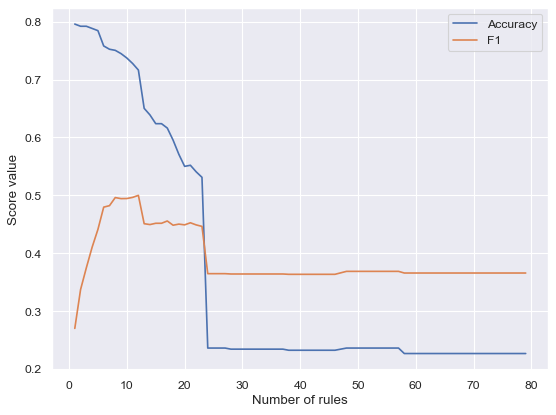

In [111]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(range(1, len(rules_cause), 1), df_eval["Accuracy"])
plt.plot(range(1, len(rules_cause), 1), df_eval["F1"])
plt.xlabel("Number of rules")
plt.ylabel("Score value")
plt.legend(['Accuracy', 'F1'])

We get the best results when using the first 9 rules.

In [112]:
rule_subset = rules_cause[0:8]
ruleset = RuleSet(rule_subset)
df = get_validation_df(ruleset, cause_val)
acc, precision, recall, f1 = evalute_ruleset(df, label="cause")

C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']==label][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']==label][df['Predicted label']=='not'])


In [113]:
print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

Accuracy: 0.6610169491525424
Precision: 0.2857142857142857
Recall: 0.2857142857142857
F1: 0.2857142857142857


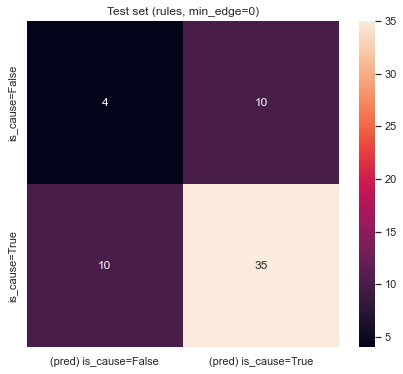

In [114]:
evaluate_class(df['True label'], df['Predicted label'], 'is_cause', 'Test set (rules, min_edge=0)')

Let's expand the rules now by adding the restriction of min_edge = 1, meaning our rules will have to have more than a term.

In [115]:
cause_train, cause_val = train_test_split(df_cause, test_size=0.1, random_state=1)

trainer = GraphTrainer(cause_train)

cause_features_1 = trainer.prepare_and_train(min_edge = 1)


Initializing trainer object...
Featurizing graphs by generating subgraphs up to 2...


529it [00:04, 108.63it/s]


Getting feature graphs...
Selecting the best features...
Generating training data...
Training...
Getting features...


In [116]:
cause_features_1["cause"][:10]

[(['(u_8 / COORD  :0 (u_106 / product))'], [], 'cause'),
 (['(u_65 / for  :2 (u_21 / condition))'], [], 'cause'),
 (['(u_8 / COORD  :1 (u_17 / influence))'], [], 'cause'),
 (['(u_8 / COORD  :0 (u_5 / disease)  :0 (u_21 / condition))'], [], 'cause'),
 (['(u_277 / factor  :0 (u_153 / risk))'], [], 'cause'),
 (['(u_12 / of  :1 (u_179 / development))'], [], 'cause'),
 (['(u_4 / with  :1 (u_89 / associate))'], [], 'cause'),
 (['(u_12 / of  :1 (u_330 / intake))'], [], 'cause'),
 (['(u_18 / in  :1 (u_21 / condition))'], [], 'cause'),
 (['(u_8 / COORD  :0 (u_5 / disease))'], [], 'cause')]

In [117]:
cause_evals_1, cause_acc_1 = trainer.evaluator.evaluate_feature("cause", cause_features_1["cause"][:10], cause_train)

In [118]:
cause_evals_1[["Feature", "Precision", "Recall", "Fscore"]]

,Feature,Precision,Recall,Fscore
0,[(u_8 / COORD :0 (u_106 / product))],0.461538,0.050847,0.091603
1,[(u_65 / for :2 (u_21 / condition))],0.333333,0.059322,0.100719
2,[(u_8 / COORD :1 (u_17 / influence))],0.352941,0.050847,0.088889
3,[(u_8 / COORD :0 (u_5 / disease) :0 (u_21 / ...,0.304348,0.059322,0.099291
4,[(u_277 / factor :0 (u_153 / risk))],0.636364,0.059322,0.108527
5,[(u_12 / of :1 (u_179 / development))],0.333333,0.042373,0.075188
6,[(u_4 / with :1 (u_89 / associate))],0.303571,0.144068,0.195402
7,[(u_12 / of :1 (u_330 / intake))],0.450000,0.076271,0.130435
8,[(u_18 / in :1 (u_21 / condition))],0.222222,0.033898,0.058824
9,[(u_8 / COORD :0 (u_5 / disease))],0.285714,0.084746,0.130719


In [119]:
rules_cause_1 = []
for i in range (len(cause_features_1['cause'])):
    splits = cause_features_1['cause'][i][0][0].split()
    feature = '(u_0'
    for i in range(1, len(splits)):
        feature += ' ' + splits[i]
    feature = ([feature],cause_features_1["cause"][i][1], cause_features_1["cause"][i][2], [{'token': 0}])
    rules_cause_1.append(Rule(feature, openie=True))

Creating a ruleset:

In [120]:
evaluations_cause_1 = []
for i in tqdm(range(1, len(rules_cause_1))):
    rule_subset = rules_cause_1[0:i]
    ruleset = RuleSet(rule_subset)
    df = get_validation_df(ruleset, cause_train)
    acc, precision, recall, f1 = evalute_ruleset(df, label="cause")
    evaluations_cause_1.append([acc, precision, recall, f1])

  0%|          | 0/34 [00:00<?, ?it/s]C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']==label][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']==label][df['Predicted label']=='not'])
100%|██████████| 34/34 [02:07<00:00,  3.75s/it]


In [121]:
df_eval = pd.DataFrame(evaluations_cause_1, columns=['Accuracy', 'Precision', 'Recall', 'F1'])

In [122]:
df_eval

,Accuracy,Precision,Recall,F1
0,0.775047,0.461538,0.050847,0.091603
1,0.761815,0.382353,0.110169,0.171053
2,0.752363,0.372549,0.161017,0.224852
3,0.731569,0.333333,0.203390,0.252632
4,0.735350,0.358974,0.237288,0.285714
5,0.727788,0.358696,0.279661,0.314286
6,0.686200,0.328571,0.389831,0.356589
7,0.678639,0.326667,0.415254,0.365672
8,0.665406,0.319018,0.440678,0.370107
9,0.655955,0.311765,0.449153,0.368056


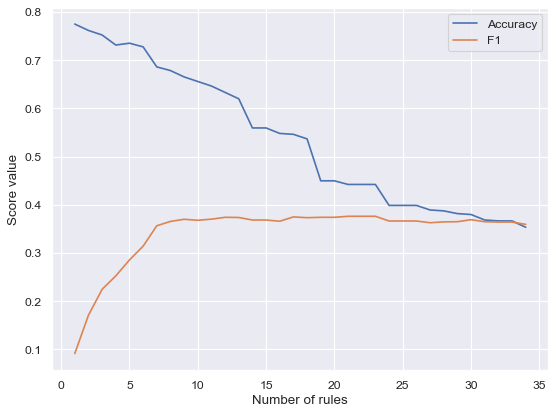

In [123]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(range(1, len(rules_cause_1), 1), df_eval["Accuracy"])
plt.plot(range(1, len(rules_cause_1), 1), df_eval["F1"])
plt.xlabel("Number of rules")
plt.ylabel("Score value")
plt.legend(['Accuracy', 'F1'])

We get the best results when using the first 9 rules.

In [124]:
rule_subset = rules_cause_1[0:8]
ruleset = RuleSet(rule_subset)
df = get_validation_df(ruleset, cause_val)
acc, precision, recall, f1 = evalute_ruleset(df, label="cause")

C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tp = len(df[df['True label']==label][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tn = len(df[df['True label']=='not'][df['Predicted label']=='not'])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = len(df[df['True label']=='not'][df['Predicted label']==label])
C:\Users\Ana\AppData\Local\Temp\ipykernel_18492\2503950197.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = len(df[df['True label']==label][df['Predicted label']=='not'])


In [125]:
print("Accuracy: "+str(acc))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1: "+str(f1))

Accuracy: 0.559322033898305
Precision: 0.22727272727272727
Recall: 0.35714285714285715
F1: 0.2777777777777778


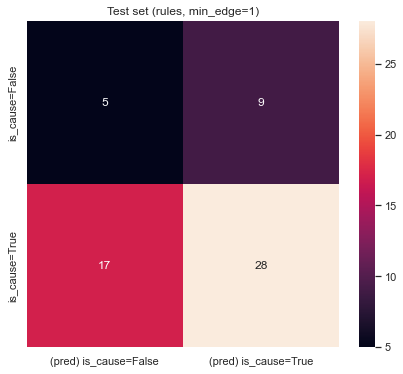

In [126]:
evaluate_class(df['True label'], df['Predicted label'], 'is_cause', 'Test set (rules, min_edge=1)')